In [26]:
import enum
import math

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from itertools import chain

import zipfile
import sys
import os
import requests
import pandas as pd
import pickle
from torch.utils.data import DataLoader, Dataset
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [27]:
# # show pytorch version and cuda version
# print(torch.__version__)
# #print(torch.version.cuda)

# #show if metal is available
# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     x = torch.ones(1, device=mps_device)
#     print (x)
# else:
#     print ("MPS device not found.")
    
# # show python version
# !python -V

# torch.set_default_dtype(torch.float32)

## collecting and preparing data

In [28]:
%pwd

'/work/postresearch/Shared/Researchers/Farbod'

In [29]:
#change working directory
os.chdir('/work/postresearch/Shared/Researchers/Farbod/')

# Financial data preparation

In [30]:
sp = pd.read_csv('sp500_data.csv', index_col=0)

#create a column called Date from index
sp['date'] = sp.index
sp['month'] = pd.DatetimeIndex(sp['date']).month
sp["day_of_week"] = pd.to_datetime(sp["date"]).dt.day_name()

#select only apple, amazon, google, microsoft, facebook
#sp = sp[sp['Stock'].isin(['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'FB'])]

# df.set_index('date', 'Stock')

sp.head()

,Open,High,Low,Close,Adj Close,Volume,Stock,date,month,day_of_week
Date,,,,,,,,,,
2000-01-03,40.159908,40.342808,39.323788,39.454430,17.557297,2599386,MMM,2000-01-03,1,Monday
2000-01-04,38.827339,39.637333,37.886707,37.886707,16.859657,3245705,MMM,2000-01-04,1,Tuesday
2000-01-05,38.095737,40.238293,38.095737,38.984116,17.348011,4424482,MMM,2000-01-05,1,Wednesday
2000-01-06,39.428303,42.851170,39.428303,42.119564,18.743286,7147057,MMM,2000-01-06,1,Thursday
2000-01-07,42.276337,43.399876,41.779892,42.955685,19.115358,4905035,MMM,2000-01-07,1,Friday


In [31]:
#normalize all columns (Open, High, Low, Close, Adj Close) of the stocks for each year (center by mean and scale by std)

# sp['year'] = pd.DatetimeIndex(sp['date']).year

#normalize all columns (Open, High, Low, Close, Adj Close) of the stocks for each year (center by mean and scale by std)
# sp['open_scaled'] = sp.groupby('year')['Open'].transform(lambda x: (x - x.mean()) / x.std())
# sp['high_scaled'] = sp.groupby('year')['High'].transform(lambda x: (x - x.mean()) / x.std())
# sp['low_scaled'] = sp.groupby('year')['Low'].transform(lambda x: (x - x.mean()) / x.std())
# sp['close_scaled'] = sp.groupby('year')['Close'].transform(lambda x: (x - x.mean()) / x.std())
# sp['adj_close_scaled'] = sp.groupby('year')['Adj Close'].transform(lambda x: (x - x.mean()) / x.std())


#save sd and mean for future use
# sd_mean = sp.groupby('year').agg({'Open': ['std', 'mean'], 'High': ['std', 'mean'], 'Low': ['std', 'mean'], 'Close': ['std', 'mean'], 'Adj Close': ['std', 'mean']})


In [32]:
#data from 2000 to 2013 is used for training and data from 2013 to 2024 is used for testing, only big tech companies are used
#sp = sp[sp.Stock.isin(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'])]
#sort by date (index)
sp = sp.sort_values(by=['date','Stock'])
sp['Stock_name'] = sp['Stock']

#scale using moving average use date column as index (rolling should be based on date)
# sp['open_scaled'] = sp.groupby('Stock')['Open'].transform(lambda x: (x / x.rolling(20).mean()))
# sp['high_scaled'] = sp.groupby('Stock')['High'].transform(lambda x: (x / x.rolling(20).mean()))
# sp['low_scaled'] = sp.groupby('Stock')['Low'].transform(lambda x: (x / x.rolling(20).mean()))
# sp['close_scaled'] = sp.groupby('Stock')['Close'].transform(lambda x: (x / x.rolling(20).mean()))
# sp['adj_close_scaled'] = sp.groupby('Stock')['Adj Close'].transform(lambda x: (x / x.rolling(20).mean()))
# sp['volume_scaled'] = sp.groupby('Stock')['Volume'].transform(lambda x: (x / x.rolling(20).mean()))

#scale using percent change from the previous day
sp['open_scaled'] = sp.groupby('Stock')['Open'].transform(lambda x: x.pct_change())
sp['high_scaled'] = sp.groupby('Stock')['High'].transform(lambda x: x.pct_change())
sp['low_scaled'] = sp.groupby('Stock')['Low'].transform(lambda x: x.pct_change())
sp['close_scaled'] = sp.groupby('Stock')['Close'].transform(lambda x: x.pct_change())
sp['adj_close_scaled'] = sp.groupby('Stock')['Adj Close'].transform(lambda x: x.pct_change())
sp['volume_scaled'] = sp.groupby('Stock')['Volume'].transform(lambda x: x.pct_change())

#find the change from the previous month (use the date column to find a month ago)
# sp['change_to_next_month'] = sp.groupby('Stock')['Close'].transform(lambda x: x.pct_change(periods=-20))
# sp['change_to_next_year'] = sp.groupby('Stock')['Close'].transform(lambda x: x.pct_change(periods=-252))

sp = sp[sp.index > '2013-01-01']
sp = sp[sp.index < '2019-01-01']

sp.head()

# sp['open_scaled'] = sp['Open'].transform(lambda x: (x - x.mean()) / x.std())
# sp['high_scaled'] = sp['High'].transform(lambda x: (x - x.mean()) / x.std())
# sp['low_scaled'] = sp['Low'].transform(lambda x: (x - x.mean()) / x.std())
# sp['close_scaled'] = sp['Close'].transform(lambda x: (x - x.mean()) / x.std())
# sp['adj_close_scaled'] = sp['Adj Close'].transform(lambda x: (x - x.mean()) / x.std())



# train_data = sp[sp.index > '2016-01-01']
# train_data = train_data[train_data.index < '2017-01-01']
# test_data = sp[sp.index >= '2017-01-01']
# test_data = test_data[test_data.index < '2018-01-01']

# train_data.head(20)

,Open,High,Low,Close,Adj Close,Volume,Stock,date,month,day_of_week,Stock_name,open_scaled,high_scaled,low_scaled,close_scaled,adj_close_scaled,volume_scaled
Date,,,,,,,,,,,,,,,,,
2013-01-02,30.164520,30.164520,29.434908,29.957083,27.193171,8790205,A,2013-01-02,1,Wednesday,A,0.062484,0.029290,0.038093,0.022960,0.022960,0.867116
2013-01-02,13.720000,14.010000,13.600000,13.980000,13.179523,6662000,AAL,2013-01-02,1,Wednesday,AAL,0.067704,0.024123,0.059190,0.035556,0.035555,-0.049046
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.747715,560518000,AAPL,2013-01-02,1,Wednesday,AAPL,0.084794,0.036608,0.064106,0.031682,0.031681,-0.150077
2013-01-02,34.919998,35.400002,34.099998,35.119999,22.002171,13767900,ABBV,2013-01-02,1,Wednesday,ABBV,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,32.299999,32.450001,31.639999,32.049999,25.748268,20266400,ABT,2013-01-02,1,Wednesday,ABT,0.049738,0.032082,0.030216,0.019827,0.019827,0.065636


In [33]:
sp.shape

(717986, 17)

## Data embedding before feeding into the model

This will first one-hot encode all the categorical features and then embed them to n columns. The resulting columns will then be concatenated with the numerical features. The result will then be used to create the torch tensor for the model. The torch tensor will be shaped as (Cases, Time, Features).

The input data will be a dataframe like this:





In [34]:
class DataEmbedder(nn.Module):
    def __init__(self, categorical_features, embedding_sizes, numerical_features, dataframe, indices):
        super(DataEmbedder, self).__init__()
        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
        self.indices = indices
        self.embeddings = nn.ModuleDict()
        self.mapping_dicts = {}
        self.embedding_sizes = embedding_sizes

        # Initialize embeddings and mapping dictionaries
        for feature, size in embedding_sizes.items():
            unique_values = dataframe[feature].unique()
            self.mapping_dicts[feature] = {name: idx for idx, name in enumerate(unique_values)}
            self.embeddings[feature] = nn.Embedding(num_embeddings=len(unique_values), embedding_dim=size)
            print(f"Feature: {feature}, Categories: {len(unique_values)}, Embedding Size: {size}")
    
    def forward(self, full_data):

        # Assuming the first part of full_data contains categorical indices and the rest are numerical values
        full_data_shape = full_data.shape

        num_categorical_features = len(self.categorical_features)
        x_cat = full_data[:, :, :num_categorical_features].long()
        x_num = full_data[:, :, num_categorical_features:]

        # Apply embeddings to the categorical indices
        embedded_features = []
        for idx, feature in enumerate(self.categorical_features):
            embedded_features.append(self.embeddings[feature](x_cat[:, :, idx]))            
        embedded_features = torch.cat(embedded_features, dim=-1)

        # Concatenate the embedded features with the numerical data
        result = torch.cat([embedded_features, x_num], dim=-1)

        unique_dates = full_data_shape[1]
        feature_count_embedded = len(self.numerical_features) + sum(self.embedding_sizes.values())

        result = result.reshape(full_data_shape[0], -1, feature_count_embedded)

        return result



    def prepare_data(self, df):
        #find unqiue values of indices from self.indices and df
        
        df = df.copy()
        unqiue_indices = []
        for index in self.indices:
            unqiue_indices.append(df[index].unique()) 

        complete_index = pd.MultiIndex.from_product(unqiue_indices, names=self.indices)
        
        df.set_index(self.indices, inplace=True)
        df = df.reindex(complete_index)
        df = df.ffill().bfill()
        df = df[self.numerical_features + self.categorical_features]

        categorical_data = [torch.tensor([self.mapping_dicts[feature].get(val, -1) for val in df[feature]], dtype=torch.long) for feature in self.categorical_features]
        if categorical_data:
            categorical_data = torch.stack(categorical_data, dim=1)

        # Convert numerical features to tensor
        numerical_data = torch.tensor(df[self.numerical_features].values, dtype=torch.float32)

        # Concatenate all features into a single tensor
        if categorical_data is None:
            full_data = numerical_data
        else:
            full_data = torch.cat([categorical_data, numerical_data], dim=1)

        unique_dates = df.index.get_level_values(1).nunique()
        feature_count_embedded = len(self.numerical_features) + sum(self.embedding_sizes.values())

        full_data = full_data.reshape(-1, unique_dates, len(self.categorical_features) + len(self.numerical_features))


        return full_data



# Transformer

## Moded Transformer

In [35]:
class moded_TimesSeriesAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors for time series data of shape (b, t, f, e)
    """

    def __init__(self, embed_dim: int, num_heads: int):
        """
        Constructor.
        
        Inputs:
        - input_dim: Dimension of the input query, key, and value. We assume they all have
          the same dimensions. This is basically the dimension of the embedding.
        - num_heads: Number of attention heads
        """
        super(moded_TimesSeriesAttention, self).__init__()

        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dim_per_head = embed_dim // num_heads


        self.linear_query = nn.Linear(embed_dim, embed_dim)
        self.linear_key = nn.Linear(embed_dim, embed_dim)
        self.linear_value = nn.Linear(embed_dim, embed_dim)#(self.num_heads * self.dim_per_head * self.dim_per_head))
        self.output_linear = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax2d()


    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor = None):
        """
        Compute the attended feature representations.
        
        Inputs:
        - query: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension, 
        and E is the embedding dimension
        - key: Tensor of the shape BxTxFXE
        - value: Tensor of the shape BxTxFXE
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]
        t = query.shape[1]
        f = query.shape[2]
        e = query.shape[3]
        d = self.dim_per_head
        h = self.num_heads


        query_linear = self.linear_query(query)
        key_linear = self.linear_key(key)
        value_linear = self.linear_value(value)

        query_reshaped = query_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        key_reshaped = key_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        value_reshaped = value_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)#, self.dim_per_head)

        query_reshaped = query_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxD
        key_reshaped = key_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxD
        value_reshaped = value_reshaped.permute(0, 3, 1, 2, 4)#, 5) # BxHxTxFxDxD


        kq = torch.einsum("bhtfd,bhxyd->bhtfxy", key_reshaped, query_reshaped)

        dot_prod_scores = kq/math.sqrt(self.dim_per_head)


        #softmax across last 2 features (use softmax2d)
        dot_prod_scores = dot_prod_scores.reshape(b*h, t*f, t, f)
        dot_prod_scores = self.softmax(dot_prod_scores)
        dot_prod_scores = dot_prod_scores.reshape(b, h, t, f, t, f)

        out = torch.einsum("bhtfxy,bhtfd->bhtfd",
                           dot_prod_scores, value_reshaped)
        out = out.permute(0, 2, 3, 1, 4).reshape(b, t, f, e)
        out = self.output_linear(out)

        return out


In [36]:
class moded_TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """

    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(moded_TransformerEncoderCell, self).__init__()

        self.time_series_attention = moded_TimesSeriesAttention(embed_dim, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        """

        attention2 = self.time_series_attention(x, x, x, mask)
        attention = x + self.dropout1(attention2)
        attention = self.layer_norm(attention)

        attention2 = self.linear2(self.dropout(
            self.activation(self.linear1(attention))))
        attention = attention + self.dropout2(attention2)
        attention = self.layer_norm(attention)

        return attention


In [37]:
class moded_TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """

    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float = 0.1):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of time series attention cells in the encoder
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(moded_TransformerEncoder, self).__init__()

        self.norm = None

        self.encoder_modules = nn.ModuleList(moded_TransformerEncoderCell(
            embed_dim, num_heads, ff_dim, dropout) for _ in range(num_cells))
        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape BxTxFXE
        """

        #run encoder modules and add residual connections
        for encoder_module in self.encoder_modules:
            x = encoder_module(x, mask)

        y = x

        return y


## RSA

In [38]:
class TimesSeriesAttention(nn.Module):
    def __init__(
        self,
        d_in,
        d_out,
        nh=8,
        dk=0,
        dv=0,
        dd=0,
        kernel_size=(3, 7),
        stride=(1,1,1),
        kernel_type='VplusR',  # ['V', 'R', 'VplusR']
        feat_type='VplusR',  # ['V', 'R', 'VplusR']
    ):
        super(TimesSeriesAttention, self).__init__()

        self.d_in = d_in
        self.d_out = d_out
        self.nh = nh
        self.dv = dv = d_out // nh if dv == 0 else dv
        self.dk = dk = dv if dk == 0 else dk
        self.dd = dd = dk if dd == 0 else dd

        self.kernel_size = kernel_size
        self.stride = stride
        self.kernel_type = kernel_type
        self.feat_type = feat_type

        assert self.kernel_type in [
            'V', 'R', 'VplusR'], "Not implemented involution type: {}".format(self.kernel_type)
        assert self.feat_type in [
            'V', 'R', 'VplusR'], "Not implemented feature type: {}".format(self.feat_type)

        # print("d_in: {}, d_out: {}, nh: {}, dk: {}, dv: {}, dd:{}, kernel_size: {}, kernel_type: {}, feat_type: {}"
        #       .format(d_in, d_out, nh, dk, dv, self.dd, kernel_size, kernel_type, feat_type))

        self.ksize = ksize = kernel_size[0] * kernel_size[1]
        self.pad = pad = tuple(k//2 for k in kernel_size)

        # hidden dimension
        d_hid = nh * dk + dv if self.kernel_type == 'V' else nh * dk + dk + dv

        # Linear projection
        #self.projection = nn.Conv2d(d_in, d_hid, 1, bias=False)
        self.projection_linear = nn.Sequential(
            nn.Linear(d_in, d_hid, bias=False),
            nn.SiLU(inplace=True),
            nn.Linear(d_hid, d_hid, bias=False)
        )

        # Intervolution Kernel
        if self.kernel_type == 'V':
            self.H2 = nn.Conv2d(1, dd, kernel_size,
                                padding=self.pad, bias=False)
        elif self.kernel_type == 'R':
            self.H1 = nn.Conv2d(dk, dk*dd, kernel_size,
                                padding=self.pad, groups=dk, bias=False)
            self.H2 = nn.Conv2d(1, dd, kernel_size,
                                padding=self.pad, bias=False)
        elif self.kernel_type == 'VplusR':
            self.P1 = nn.Parameter(torch.randn(dk, dd).unsqueeze(
                0)*np.sqrt(1/(ksize*dd)), requires_grad=True)
            self.H1 = nn.Conv2d(dk, dk*dd, kernel_size,
                                padding=self.pad, groups=dk, bias=False)
            self.H2 = nn.Conv2d(1, dd, kernel_size,
                                padding=self.pad, bias=False)
        else:
            raise NotImplementedError

        # Feature embedding layer
        if self.feat_type == 'V':
            pass
        elif self.feat_type == 'R':
            self.G = nn.Conv2d(1, dv, kernel_size,
                               padding=self.pad, bias=False)
        elif self.feat_type == 'VplusR':
            self.G = nn.Conv2d(1, dv, kernel_size,
                               padding=self.pad, bias=False)
            self.I = nn.Parameter(torch.eye(dk).unsqueeze(0), requires_grad=True)
        else:
            raise NotImplementedError

        # Downsampling layer
        if max(self.stride) > 1:
            self.avgpool = nn.AvgPool2d(kernel_size=(
                1, 3), stride=(1, 2), padding=(0, 1))

    def L2norm(self, x, d=1):
        eps = 1e-6
        norm = x ** 2
        norm = norm.sum(dim=d, keepdim=True) + eps
        norm = norm ** (0.5)
        return (x / norm)

    def forward(self, x):
                
        #print(x.shape)
        x = x.permute(0, 3, 1, 2)
        N, C, T, H= x.shape

        x = x.permute(0, 2, 3, 1)
        
        '''Linear projection'''
        #x_proj = self.projection(x)
        x_proj = self.projection_linear(x)
        x_proj = x_proj.permute(0, 3, 1, 2)
        #print(x_proj.shape)

        if self.kernel_type != 'V':
            q, k, v = torch.split(
                x_proj, [self.nh * self.dk, self.dk, self.dv], dim=1)
        else:
            q, v = torch.split(x_proj, [self.nh * self.dk, self.dv], dim=1)

        '''Normalization'''
        q = rearrange(q, 'b (nh k) t h -> b nh k t h', k=self.dk)
        q = self.L2norm(q, d=2)
        q = rearrange(q, 'b nh k t h -> (b t h) nh k')

        v = self.L2norm(v, d=1)

        if self.kernel_type != 'V':
            k = self.L2norm(k, d=1)

        '''
        q = (b t h) nh k
        k = b k t h
        v = b v t h
        '''

        #Intervolution generation
        # Basic kernel
        if self.kernel_type == 'V':
            kernel = q
        # Relational kernel
        else:
            K_H1 = self.H1(k)
            K_H1 = rearrange(K_H1, 'b (k d) t h-> (b t h) k d', k=self.dk)

            if self.kernel_type == 'VplusR':
                K_H1 = K_H1 + self.P1

            kernel = torch.einsum(
                'abc,abd->acd', q.transpose(1, 2), K_H1)  # (bth, nh, d)

        #feature generation
        # Appearance feature
        v = rearrange(v, 'b (v 1) t h-> (b v) 1 t h')

        V = self.H2(v)  # (bv, d, t, h)
        feature = rearrange(V, '(b v) d t h -> (b t h) v d', v=self.dv)

        # Relational feature
        if self.feat_type in ['R', 'VplusR']:
            V_G = self.G(v)  # (bv, v2, t, h)
            V_G = rearrange(V_G, '(b v) v2 t h -> (b t h) v v2', v=self.dv)

            if self.feat_type == 'VplusR':
                V_G = V_G + self.I

            feature = torch.einsum('abc,abd->acd', V_G, feature)  # (bth, v2, d)

        #kernel * feat
        out = torch.einsum('abc,adc->adb', kernel, feature)  # (bth, nh, v2)

        out = rearrange(out, '(b t h) nh v -> b (nh v) t h', t=T, h=H)

        if max(self.stride) > 1:
            out = self.avgpool(out)

        out = out.permute(0, 2, 3, 1)

        return out


In [39]:
class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """

    def __init__(self, embed_dim: int, num_heads: int, kernel_size, ff_dim: int, dropout: float):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()

        self.time_series_attention = TimesSeriesAttention(embed_dim, embed_dim, nh = num_heads, kernel_size=kernel_size)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)


    def forward(self, data: torch.Tensor,embeddings, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        """

        #attention2 = self.time_series_attention(x, x, x, mask)
        attention2 = self.time_series_attention(data)
        attention = data + self.dropout1(attention2)
        attention = self.layer_norm(attention)

        attention2 = self.linear2(self.dropout(self.activation(self.linear1(attention))))
        attention = attention + self.dropout2(attention2)
        attention = self.layer_norm(attention)

        return attention

In [40]:
class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, embed_dim: int, num_heads: int, kernel_size, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of time series attention cells in the encoder
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()
        
        self.norm = None

        self.encoder_modules = nn.ModuleList(TransformerEncoderCell(embed_dim, num_heads, kernel_size, ff_dim, dropout) for _ in range(num_cells))
        self.layer_norm = nn.LayerNorm(embed_dim)

        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape BxTxFXE
        """

        #run encoder modules and add residual connections
        for encoder_module in self.encoder_modules:
            x = encoder_module(x, mask)

        y = x

        return y

## CSDI transformer

In [41]:
def get_torch_trans(num_heads=8, num_cells=1, embed_dim=128, ff_dim=512, dropout=0.1):
    encoder_layer = nn.TransformerEncoderLayer(
        d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, activation="gelu", dropout=dropout
    )
    return nn.TransformerEncoder(encoder_layer, num_layers=num_cells)

## Embeddings

In [42]:
class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim, projection_dim=None):
        super(DiffusionEmbedding, self).__init__()
        if projection_dim is None:
            projection_dim = embedding_dim
        self.register_buffer(
            "embedding",
            self._build_embedding(num_steps, embedding_dim / 2),
            persistent=False,
        )
        self.projection1 = nn.Linear(embedding_dim, projection_dim)
        self.projection2 = nn.Linear(projection_dim, embedding_dim)        

    def forward(self, diffusion_step, data, device="cpu"):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        x = torch.zeros(data.shape).to(device) + x.unsqueeze(1).unsqueeze(1)
        return x

    def _build_embedding(self, num_steps, dim=64):
        steps = torch.arange(num_steps).unsqueeze(1)  # (T,1)
        frequencies = 10.0 ** (torch.arange(dim) / (dim - 1) * 4.0).unsqueeze(0)  # (1,dim)
        table = steps * frequencies  # (T,dim)
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)  # (T,dim*2)
        return table
    

class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_len=10000.0):
        super(TimeEmbedding, self).__init__()
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )
        

    def forward(self, data, device="cpu"):

        b, l, f, e = data.shape
        pe = None
        pe_row = torch.arange(l)

        pe = pe_row.unsqueeze(0)
        pe = pe.unsqueeze(2)

        pe = pe.repeat((b,1,e))
        pe = pe.float()

        pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2]/(self.max_len**(torch.arange(0, e, 2)/e)))
        pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2]/(self.max_len**(torch.arange(0, e, 2)/e)))

        pe = pe.to(device).unsqueeze(2).repeat((1,1,f,1))

        # pe = torch.arange(l).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
        # pe = torch.zeros(data.shape).to(device) + pe
        
        # div_term = 1 / torch.pow(
        #     self.max_len, torch.arange(0, f, 2) / f
        # ).unsqueeze(-1).to(device)

        # pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2] * div_term)
        # pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2] * div_term)

        return self.learnable(pe) 
    
class FeatureEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_len=10000.0):
        super(FeatureEmbedding, self).__init__()
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )
        

    def forward(self, data, device="cpu"):
        b, l, f, e = data.shape

        pe = None
        pe_row = torch.arange(f)

        pe = pe_row.unsqueeze(0)
        pe = pe.unsqueeze(2)

        pe = pe.repeat((b,1,e))
        pe = pe.float()

        pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2]/(self.max_len**(torch.arange(0, e, 2)/e)))
        pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2]/(self.max_len**(torch.arange(0, e, 2)/e)))

        pe = pe.to(device).unsqueeze(1).repeat((1,l,1,1))

        # pe = torch.arange(f).unsqueeze(0).unsqueeze(0).unsqueeze(-1).to(device)
        # pe = torch.zeros(data.shape).to(device) + pe

        # div_term = 1 / torch.pow(
        #     self.max_len, torch.arange(0, e, 2) / e
        # ).to(device)

        # pe[:, :, :, 0::2] = torch.sin(pe[:, :, :, 0::2] * div_term)
        # pe[:, :, :, 1::2] = torch.cos(pe[:, :, :, 1::2] * div_term)

        return self.learnable(pe)

# Residual block

In [43]:
def Conv1d_with_init(in_channels, out_channels, kernel_size):
    layer = nn.Conv1d(in_channels, out_channels, kernel_size)
    nn.init.kaiming_normal_(layer.weight)
    return layer

In [44]:
class ResidualBlock(nn.Module):
    def __init__(self, num_heads=8, num_cells=1, kernel_size=(3, 7), embed_dim=128, ff_dim=512, dropout=0.1, method = "rsa"):
        super().__init__()

        self.method = method

        self.embedding_add = nn.Sequential(
            nn.Linear(embed_dim*4, embed_dim*4),
            nn.SiLU(),
            nn.Linear(embed_dim*4, embed_dim*2),
            nn.SiLU(),
            nn.Linear(embed_dim*2, embed_dim)
        )
        


        self.layer_norm = nn.LayerNorm(embed_dim)
        
        self.mid_projection = Conv1d_with_init(embed_dim, 2 * embed_dim, 1)
        #nn.Linear(embed_dim, embed_dim*2)
        self.output_projection = Conv1d_with_init(embed_dim, 2 * embed_dim, 1)
        #self.output_projection = nn.Linear(embed_dim, embed_dim*2)

        if method == "rsa":
            self.feature_and_time_transformer = TransformerEncoder(embed_dim = embed_dim,
                                              num_heads = num_heads,
                                              kernel_size=kernel_size,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
            
        elif method == "csdi":
            self.time_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.feature_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)
        
        elif method == "csdi_moded_transformer":
            self.time_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.feature_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)
            self.feature_and_time_transformer = moded_TransformerEncoder(embed_dim=embed_dim,
                                                                   num_heads=num_heads,
                                                                   ff_dim=ff_dim,
                                                                   num_cells=num_cells,
                                                                   dropout=dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
        
        elif method == "rsa_csdi":
            self.time_layer = get_torch_trans(
                num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.feature_layer = get_torch_trans(
                num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)
            self.feature_and_time_transformer = TransformerEncoder(embed_dim = embed_dim,
                                              num_heads = num_heads,
                                              kernel_size=kernel_size,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)

        
        elif method == "rsa_moded_transformer":
            self.feature_and_time_transformer = TransformerEncoder(embed_dim = embed_dim,
                                              num_heads = num_heads,
                                              kernel_size=kernel_size,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
            self.moded_feature_and_time_transformer = moded_TransformerEncoder(embed_dim=embed_dim,
                                                                   num_heads=num_heads,
                                                                   ff_dim=ff_dim,
                                                                   num_cells=num_cells,
                                                                   dropout=dropout)
            self.moded_linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
        
        elif method == "moded_transformer_alone":
            self.moded_feature_and_time_transformer = moded_TransformerEncoder(embed_dim=embed_dim,
                                                                   num_heads=num_heads,
                                                                   ff_dim=ff_dim,
                                                                   num_cells=num_cells,
                                                                   dropout=dropout)
            self.moded_linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
        
        else:
            raise NotImplementedError


        
        
    def forward_time(self, y, base_shape):
        b, t, f, e = base_shape
        y = y.permute(0, 2, 1, 3).reshape(b * f, t, e)
        y = self.time_layer(y.permute(1, 0, 2)).permute(1, 0, 2)
        y = y.reshape(b, f, t, e).permute(0, 2, 1, 3)
        return y

    def forward_feature(self, y, base_shape):
        b, t, f, e = base_shape
        y = y.reshape(b * t, f, e)
        y = self.feature_layer(y.permute(1, 0, 2)).permute(1, 0, 2)
        y = y.reshape(b, t, f, e)
        return y        


    def forward(self, noised_data, diffusion_emb, time_emb, feature_emb):

        b, t, f, e = noised_data.shape
        base_shape = noised_data.shape
        
        y = torch.stack((noised_data, diffusion_emb, time_emb, feature_emb), dim = -1)
        y = y.reshape(b, t, f, -1)
        y = self.embedding_add(y)
        y_resid = y

        if self.method == "rsa":
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)
        
        elif self.method == "csdi":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape) 
            y = self.linear_feature(y)
        
        elif self.method == "csdi_moded_transformer":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape) 
            y = self.linear_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y_resid = y
            y = self.layer_norm(y)
            y = self.feature_and_time_transformer(y)
            y = self.linear_time_and_feature(y)
        
        elif self.method == "rsa_csdi":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape) 
            y = self.linear_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y_resid = y
            y = self.layer_norm(y)
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)
        
        elif self.method == "rsa_moded_transformer":
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.moded_feature_and_time_transformer(y)
            y = self.moded_linear_time_and_feature(y)
        
        elif self.method == "moded_transformer_alone":
            y = self.moded_feature_and_time_transformer(y)
            y = self.moded_linear_time_and_feature(y)

        
        y = (y + y_resid) / math.sqrt(2.0)
        y = self.layer_norm(y)
        y = y.permute(0, 3, 1, 2).reshape(b, e, t*f)
        y = self.mid_projection(y)
        #y = y.permute(0, 3, 2, 1).reshape(b, 2*e, t*f)

        gate, filter = torch.chunk(y, 2, dim=1)
        y = torch.sigmoid(gate) * torch.tanh(filter)  # (b,e,f*t)
        #y = y.permute(0, 2, 1)
        y = self.output_projection(y)
        #y = y.permute(0, 2, 1)

        residual, skip = torch.chunk(y, 2, dim=1)
        residual = residual.permute(0, 2, 1)
        skip = skip.permute(0, 2, 1)
        residual = residual.reshape(base_shape)
        skip = skip.reshape(base_shape)
        return (noised_data + residual) / math.sqrt(2.0), skip

In [45]:
class ModelLoop(nn.Module):
    def __init__(self, embed_dim=128, diffusion_steps = 1000, num_heads=8, kernel_size=(3, 7),num_cells=1, num_residual_layers = 4, ff_dim=512, dropout=0.1, method = "rsa", device = "cpu"):
        super().__init__()

        self.device = device
        self.emb_dim = embed_dim

        # self.data_embedding_linear = nn.Sequential(
        #     nn.Linear(1, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, self.emb_dim)
        # ) 
        # self.x_embedding = nn.Sequential(
        #     nn.Linear(1, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, self.emb_dim)
        # ) 

        self.data_embedding_linear = Conv1d_with_init(1, self.emb_dim, 1)
        self.x_embedding = Conv1d_with_init(2, self.emb_dim, 1)
        
        self.output = Conv1d_with_init(self.emb_dim, 1, 1)
        self.output_final = Conv1d_with_init(self.emb_dim, 1, 1)
        
        # self.x_add = nn.Sequential(
        #     nn.Linear(embed_dim*num_residual_layers, embed_dim*num_residual_layers),
        #     nn.SiLU(),
        #     nn.Linear(embed_dim*num_residual_layers, embed_dim)
        # )

        
        self.diffusion_embedding = DiffusionEmbedding(diffusion_steps, embed_dim)
        self.time_embedding = TimeEmbedding(embed_dim)
        self.feature_embedding = FeatureEmbedding(embed_dim)

        self.residual_layers = nn.ModuleList(
                ResidualBlock(
                    num_heads=num_heads,
                    num_cells=num_cells,
                    kernel_size=kernel_size,
                    embed_dim=embed_dim,
                    ff_dim=ff_dim,
                    dropout=dropout,
                    method = method
                ) for _ in range(num_residual_layers)
        )
    
        # self.output = nn.Sequential(
        #     nn.Linear(self.emb_dim, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, 1)
        # )

        # self.output_final = nn.Sequential(
        #     nn.Linear(self.emb_dim, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, 1)
        # )


    def forward(self, noised_data, noise_mask, diffusion_t):

        b, t, f, a = noised_data.shape
        
        noised_data_reshaped = noised_data.permute(0, 3, 1, 2).reshape(b, 1, t*f)
        noised_data_embedded = self.data_embedding_linear(noised_data_reshaped).permute(0, 2, 1).reshape(b, t, f, self.emb_dim)
        diffusion_embedding = self.diffusion_embedding(diffusion_t, noised_data_embedded, device = self.device)
        time_embedding = self.time_embedding(noised_data_embedded, device = self.device)
        feature_embedding = self.feature_embedding(noised_data_embedded, device = self.device)

        x = noised_data_embedded
        skip = []
        for layer in self.residual_layers:
            x, skip_connection = layer(x, diffusion_embedding, time_embedding, feature_embedding)
            skip.append(skip_connection)
            x = x.permute(0, 3, 1, 2).reshape(b, self.emb_dim, t*f)
            x = self.output(x).permute(0, 2, 1).reshape(b, t, f)
            x = torch.stack((x, noised_data.squeeze(-1)), dim = -1)
            #x = x * noise_mask + noised_data * (1 - noise_mask)
            x = x.permute(0, 3, 1, 2).reshape(b, 2, t*f)
            x = self.x_embedding(x).permute(0, 2, 1).reshape(b, t, f, self.emb_dim)

        x = torch.sum(torch.stack(skip, dim = -1), dim=-1)/ math.sqrt(len(self.residual_layers))
        # x = torch.stack(skip, dim = -1).reshape(b, t, f, -1)
        #x = self.x_add(x)
        x = x.permute(0, 3, 1, 2).reshape(b, self.emb_dim, t*f)
        x = self.output_final(x).permute(0, 2, 1).reshape(b, t, f, 1).squeeze(-1)

        return x

# Beta Schedules

In [46]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start, beta_end, num_diffusion_timesteps
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    elif schedule_name == "quadratic":
        scale = 50 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.5
        return torch.linspace(
            beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps
        ) ** 2

    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.tensor(betas)

# Imputer

In [47]:
class diffusion_imputation(nn.Module):
    def __init__(self, emb_dim, excluded_features = None,
                #vocab_size,
                #pad_idx= None,
                strategy = "random",
                num_residual_layers = 4,
                features_to_impute = None,
                last_n_time = 1,
                missing_prp = 0.1,
                diffusion_steps = 1000,
                diffusion_beta_schedule = "quadratic",
                num_heads = 8,
                kernel_size=(3, 7),
                ff_dim = 512,
                num_cells = 2,
                dropout = 0.1,
                method = "rsa",
                device = "cpu"):
        
        super().__init__()

    
        self.device = device
        self.emb_dim = emb_dim
        self.strategy = strategy
        self.features_to_impute = features_to_impute
        self.missing_prp = missing_prp
        self.diffusion_steps = diffusion_steps
        self.last_n_time = last_n_time
        self.exclude_features = excluded_features   

        #set device to cuda if available
        if torch.cuda.is_available():
            self.device = "cuda"

        
        self.model_loop = ModelLoop(embed_dim = self.emb_dim,
                                    diffusion_steps = diffusion_steps,
                                    num_heads = num_heads,
                                    kernel_size = kernel_size,
                                    ff_dim = ff_dim,
                                    num_cells = num_cells,
                                    dropout = dropout,
                                    num_residual_layers = num_residual_layers,
                                    method = method,
                                    device = self.device)
        
        self.beta = get_named_beta_schedule(diffusion_beta_schedule, 
                                            diffusion_steps)
        
        #self.beta = torch.linspace(0.0001, 0.5, diffusion_steps)

        # self.beta = torch.linspace(
        #         0.0001 ** 0.5, 0.5 ** 0.5, diffusion_steps
        #     ) ** 2
        
        self.alpha_hat = 1 - self.beta 
        self.alpha = torch.cumprod(self.alpha_hat, dim=0)
        self.alpha_torch = torch.tensor(self.alpha).float()

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)


    def get_mask(self, data, strategy = "random"):
        
        b = data.shape[0]
        t = data.shape[1]
        f = data.shape[2]

        if strategy == "forecasting":
            forecasted_time = torch.randint(2, t, (b, 1, 1))
            mask = torch.zeros_like(data)
            for i in range(b):
                mask[i, forecasted_time[i]:, :] = 1

        if strategy == "forecasting_last_n_time":
            mask = torch.zeros_like(data)
            mask[:, -self.last_n_time, :] = 1

        if strategy == "death_prediction":
            mask = torch.zeros_like(data)
            #death is the last 7 columns of the data
            mask[:,:, -1] = 1
        
        if strategy == "random_features":
            selected_features = torch.randint(0, f, (b, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, :, selected_features] = 1
        
        if strategy == "selected_features":
            mask = torch.zeros_like(data)
            mask[:, :, self.features_to_impute] = 1
        
        if strategy == "selected_features_after_time":
            selected_time = torch.randint(1, t, (b, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, selected_time:, self.features_to_impute] = 1

        if strategy == "selected_features_last_n_time":
            mask = torch.zeros_like(data)
            mask[:, -self.last_n_time:, self.features_to_impute] = 1
        
        if strategy == "random":
            mask = torch.rand(size=(b, t, f))
            mask = mask < self.missing_prp
            mask = mask.float()

        if self.exclude_features is not None:
            mask[:, :, self.exclude_features] = 0

        return mask
    
    def loss_func(self, predicted_noise, noise, noise_mask):
        # noise = torch.nan_to_num(noise, nan=0.0)
        # predicted_noise = torch.nan_to_num(predicted_noise, nan=0.0)
        residual = noise - predicted_noise
        num_obs = torch.sum(noise_mask)
        loss = (residual**2).sum() / num_obs
        return(loss)
    
    def forward(self, data):
         
        b, t, f = data.shape

        noise_mask = self.get_mask(data, self.strategy).to(self.device)
        noise = torch.randn((b, t, f)).to(self.device)
        noise = (noise_mask * noise)

        diffusion_t = torch.randint(0, self.diffusion_steps, (b,1)).squeeze(1)
        alpha = self.alpha_torch[diffusion_t].unsqueeze(1).unsqueeze(2).to(self.device)

        noised_data = data * noise_mask
        noised_data = noised_data * (alpha**0.5) + noise * ((1 - alpha)**0.5)
        conditional_data = data * (1 - noise_mask)
        noised_data = noised_data + conditional_data
        noised_data = noised_data.float()

        predicted_noise = self.model_loop(noised_data.unsqueeze(3), noise_mask.unsqueeze(3), diffusion_t)
        predicted_noise = predicted_noise * noise_mask

        return (predicted_noise, noise, noise_mask)
    
    def eval_with_grad(self, data, scale=1):

        #with torch.no_grad():
        imputation_mask = self.get_mask(data, self.strategy).to(self.device)
        conditional_data = data * (1 - imputation_mask)
        random_noise = torch.randn_like(data)* imputation_mask * scale
        data_2 = (conditional_data + random_noise).unsqueeze(3)

        b, ti, f, e = data_2.shape
        imputed_samples = torch.zeros((b, ti, f)).to(self.device)
        x = (conditional_data + random_noise)

        for t in range(self.diffusion_steps - 1, -1, -1):

            x = x.unsqueeze(3).float()
            predicted_noise = self.model_loop(x, imputation_mask.unsqueeze(3), torch.tensor([t]).to(self.device))
            predicted_noise = predicted_noise * imputation_mask
            
            coeff1 = 1 / self.alpha_hat[t] ** 0.5
            coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5
            
            x = x.squeeze(3)
            x = coeff1 * (x - coeff2 * predicted_noise)
            
            if t > 0:
                noise = torch.randn_like(x)
                sigma = (
                    (1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]
                ) ** 0.5
                x += sigma * noise
            
            x = data_2.squeeze(3) * (1 - imputation_mask) + x * imputation_mask
            
            imputed_samples = x

        return(imputed_samples, data, imputation_mask)

    
    def eval(self, data, imputation_mask, scale=1 , verbose = True):
        
        conditional_data = data * (1 - imputation_mask)
        random_noise = torch.randn_like(data)* imputation_mask *scale
        data_2 = (conditional_data + random_noise).unsqueeze(3)

        b, ti, f, e = data_2.shape
        imputed_samples = torch.zeros((b, ti, f)).to(self.device)
        x = (conditional_data + random_noise)

        with torch.no_grad():

            for t in range(self.diffusion_steps - 1, -1, -1):

                x = x.unsqueeze(3).float()
                predicted_noise = self.model_loop(x, imputation_mask.unsqueeze(3), torch.tensor([t]).to(self.device))
                predicted_noise = predicted_noise * imputation_mask
                
                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5
                
                x = x.squeeze(3)
                x = coeff1 * (x - coeff2 * predicted_noise)
                
                if t > 0:
                    noise = torch.randn_like(x)
                    sigma = (
                        (1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]
                    ) ** 0.5
                    x += sigma * noise
                
                x = data_2.squeeze(3) * (1 - imputation_mask) + x * imputation_mask
            

            imputed_samples = x.detach()
        mae = torch.mean(torch.abs(data[imputation_mask !=0] - imputed_samples[imputation_mask !=0])).item()
        if verbose == True:
            print("mae = ", mae)
        # data_to_print = data[imputation_mask !=0]
        # imputed_samples_to_print = imputed_samples[imputation_mask !=0]
        # print("data:", data_to_print)
        # print("imputed:", imputed_samples_to_print)
        # print("absolute difference in the first 100 : ", torch.abs(data_to_print - imputed_samples_to_print)[:100])
        # print("mae = ", torch.mean(torch.abs(data_to_print - imputed_samples_to_print)).item())

        return(imputed_samples, data, imputation_mask, mae)

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HybridModel(nn.Module):
    def __init__(self, diffusion_imputer, categorical_features_info, num_layers, device="cuda"):
        super().__init__()
        self.diffusion_imputer = diffusion_imputer
        self.categorical_features_info = categorical_features_info
        self.device = device

        # Flatten indices for categorical features
        self.categorical_indices = [idx for info in categorical_features_info for idx in info['indices']]
        self.target_categorical_indices = [idx for info in categorical_features_info for idx in info['indices_target']]

        # Define layers
        self.first_linear_layers = nn.ModuleList([
            nn.Linear(info['embedding_dim'], info['hidden_dim'])
            for info in categorical_features_info
        ])
        self.second_linear_layers = nn.ModuleList([
            nn.Linear(info['hidden_dim'], info['hidden_dim'])
            for info in categorical_features_info
        ])
        num_total_features_and_hidden_dims = sum(info['hidden_dim'] for info in categorical_features_info)

        self.first_layer_ff = nn.Linear(num_total_features_and_hidden_dims, num_total_features_and_hidden_dims)
        self.classification_layers = nn.ModuleList([
            nn.Linear(num_total_features_and_hidden_dims, num_total_features_and_hidden_dims) for _ in range(num_layers)
        ])
        self.output_layers = nn.ModuleList([
            nn.Linear(num_total_features_and_hidden_dims, info['num_classes']) for info in categorical_features_info
        ])

        self.relu = nn.ReLU()

    def forward(self, data, target_data):
        imputed_samples, _, imputation_mask = self.diffusion_imputer.eval_with_grad(data)
        # imputation_results = torch.where(imputation_mask != 0, imputed_samples, data)

        # Use precomputed indices to split data
        target_data_categorical = target_data[:, :, self.target_categorical_indices]
        target_data_numerical = target_data[:, :, [i for i in range(target_data.shape[2]) if i not in self.target_categorical_indices]]
        imputation_results_categorical = imputed_samples[:, :, self.categorical_indices]
        imputation_results_numerical = imputed_samples[:, :, [i for i in range(data.shape[2]) if i not in self.categorical_indices]]
        # Process categorical data
        # print(imputation_results_categorical[-1])
        start_idx = 0
        class_predictions = []
        for first_layer, second_layer, info in zip(self.first_linear_layers, self.second_linear_layers, self.categorical_features_info):
            end_idx = start_idx + info['embedding_dim']
            feature_data = imputation_results_categorical[:, :, start_idx:end_idx]
            feature_data = self.relu(first_layer(feature_data))
            feature_data = self.relu(second_layer(feature_data))
            class_predictions.append(feature_data)
            start_idx = end_idx
        combined_data_categorical = torch.cat(class_predictions, dim=2)
        combined_data_categorical = self.relu(self.first_layer_ff(combined_data_categorical))
        for layer in self.classification_layers:
            combined_data_categorical = self.relu(layer(combined_data_categorical))        
        temp_final_outputs = [output_layer(combined_data_categorical).unsqueeze(2) for output_layer in self.output_layers]
        final_outputs_categorical = torch.cat(temp_final_outputs, dim=2)
        final_outputs_categorical = torch.softmax(final_outputs_categorical, dim=3)

        return imputation_results_numerical, final_outputs_categorical, target_data_numerical, target_data_categorical

    def loss_func(self, outputs, targets):
        imputation_results_numerical, final_outputs_categorical = outputs
        target_numerical, target_categorical = targets
        
        # loss_numerical = F.mse_loss(imputation_results_numerical, target_numerical)
        final_outputs_categorical = final_outputs_categorical.view(-1, final_outputs_categorical.shape[2], final_outputs_categorical.shape[3])
        target_categorical = target_categorical.view(-1, target_categorical.shape[2])
        target_categorical = target_categorical.long().to(self.device)
        # print(final_outputs_categorical.shape)
        # print(target_categorical.shape)
        loss_categorical = sum(F.cross_entropy(final_outputs_categorical[:, i, :].squeeze(), target_categorical[:, i].squeeze()) for i in range(final_outputs_categorical.shape[1]))

        # print(final_outputs_categorical.shape)
        print(target_categorical[-2])
        print(final_outputs_categorical[-2])
        print(target_categorical[2])
        print(final_outputs_categorical[2])
        # print(loss_numerical)
        # print(loss_categorical)
        # return loss_numerical + loss_categorical
        return loss_categorical 

    def eval(self, data, imputation_mask):
        # self.eval()
        with torch.no_grad():
            imputed_samples, _, _ = self.diffusion_imputer.eval_with_grad(data, imputation_mask)
            imputation_results = torch.where(imputation_mask != 0, imputed_samples, data)

            imputation_results_categorical = imputation_results[:, :, self.categorical_indices]
            imputation_results_numerical = imputation_results[:, :, [i for i in range(data.shape[2]) if i not in self.categorical_indices]]

            start_idx = 0
            class_predictions = []
            for first_layer, second_layer, info in zip(self.first_linear_layers, self.second_linear_layers, self.categorical_features_info):
                end_idx = start_idx + info['embedding_dim']
                feature_data = imputation_results_categorical[:, :, start_idx:end_idx]
                feature_data = F.relu(first_layer(feature_data))
                feature_data = F.relu(second_layer(feature_data))
                class_predictions.append(feature_data)
                start_idx = end_idx

            combined_data_categorical = torch.cat(class_predictions, dim=2)
            combined_data_categorical = F.relu(self.first_layer_ff(combined_data_categorical))
            for layer in self.classification_layers:
                combined_data_categorical = F.relu(layer(combined_data_categorical))

            final_outputs_categorical = torch.cat([
                output_layer(combined_data_categorical).unsqueeze(2) for output_layer in self.output_layers
            ], dim=2)
            final_outputs_categorical = torch.argmax(final_outputs_categorical, dim=2)

            final_outputs = torch.cat([imputation_results_numerical, final_outputs_categorical], dim=2)
            return final_outputs


# Training

In [49]:
#create a train function that also shows a dynamic loss plot. It should also be batched. 
#the plot should be dynamic and show the loss for each epoch.
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time
import statistics

def train(model, data_loader, data_loader_validation, epochs, lr, loss_func, batch_embedder,
          windowed_mode = False, min_window = 50, max_window = 100, 
           annealing_window = True,
           annealing_multiplier = 1.25, device = "cuda", verbose = True,
           validation_frequency = 1, validation_prp = 10):#, strategy = "random"):


    batch_embedder = batch_embedder.to(device)
    model = model.to(device)
    #annealing for the learning rate

    optimizer = torch.optim.Adam(
        chain(batch_embedder.parameters(), model.parameters()),
        lr=lr
    )

    model.train()
    batch_embedder.train()
    loss_list = []
    fig = plt.figure()
    ax = fig.add_subplot(111)
    epoch_loss = 0
    epoch_loss_list = []
    mae = 0
    val_loss = 0
    for epoch in range(epochs):
        #annealing for the learning rate (if the loss has not decreased in the last 2 epochs, divide the learning rate by 2)
        if annealing_window:
            if epoch > annealing_window:
                if epoch_loss >= annealing_multiplier*(statistics.mean(epoch_loss_list[-annealing_window:])):
                    for g in optimizer.param_groups:
                        g['lr'] = g['lr'] * 0.9

        start = time.time()
        for i, batch in enumerate(data_loader):
            
            batch = batch.to(device)
            batch = batch_embedder(batch)

            cut_start = 0
            cut_end = 0
            #when strategy is forecasting_last_n_time, cut the batch at a random time and forecast the last n times from the end of that cut. Never cut such that the the length of the cut is less than 2n.
            if windowed_mode == True:
                while cut_end - cut_start <= min_window or cut_end - cut_start >= max_window:
                    cut_start = torch.randint(0, batch.shape[1], (1,)).item()
                    cut_end = torch.randint(0, batch.shape[1], (1,)).item()
                batch = batch[:, cut_start:cut_end, :]


            optimizer.zero_grad()
            predicted_noise, noise, noise_mask = model(batch.to(device))
            loss = loss_func(predicted_noise, noise, noise_mask)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            if i % 2 == 0:       
                ax.clear()
                ax.set_ylim(0, 1)
                ax.plot(loss_list)
                #ax.text(len(loss_list) - 1, loss_list[-1], str(round(loss_list[-1], 3)))
                #add a smooth line to the plot every 100 steps
                if len(loss_list) > 100:
                    ax.plot(np.convolve(loss_list, np.ones((100,))/100, mode='valid'))
                    #show the last loss value on the plot
                    ax.text(len(loss_list) - 1, np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1],
                             str(round(np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1], 3)))
                ax.text(0.1, 0.9, "Epoch: " + str(epoch) + " Loss: " + str(round(epoch_loss, 3)))
                ax.text(0.1, 0.8, "Learning rate: " + str(round(optimizer.param_groups[0]['lr'], 9)))
                ax.text(0.1, 0.7, "Validation loss: " + str(round(val_loss, 3)))
                display(fig)
                clear_output(wait=True)
            #print("Epoch: ", epoch, "Loss: ", loss.item())
        end = time.time()    
        
        if verbose:
            #add the epoch average loss to the plot
            #find the number of batches in the epoch
            num_batches = len(data_loader)
            #find the average loss for the epoch
            epoch_loss = sum(loss_list[-num_batches:]) / num_batches
            epoch_loss_list.append(epoch_loss)
        
        #validation at the end of each n epoch

        if epoch % validation_frequency == 0:
            #mae_list = []
            loss_list_validation = []
            
            for i, batch in enumerate(data_loader_validation):
                batch = batch.to(device)
                batch = batch_embedder(batch)
                
                if i % validation_prp == 0:
                    test_data = batch.to(device)
                    # # imputation_mask = diffusion_imputation.get_mask(model, test_data, strategy).to(device)
                    # # imputed_step, data_step, imputation_mask_step, mae_step = diffusion_imputation.eval(model, test_data, imputation_mask, verbose=False)
                    # imputation_mask = model.get_mask(test_data).to(device)
                    # imputed_step, data_step, imputation_mask_step, mae_step = model.eval(test_data, imputation_mask, verbose=False)
                    # # imputed_samples = torch.cat((imputed_samples, imputed_step), dim = 0)
                    # # data = torch.cat((data, data_step), dim = 0)
                    # # imputation_mask = torch.cat((imputation_mask, imputation_mask_step), dim = 0)
                    # mae_list.append(mae_step)
                    predicted_noise, noise, noise_mask = model(test_data)
                    loss = loss_func(predicted_noise, noise, noise_mask)
                    loss_list_validation.append(loss.item())

            val_loss = np.mean(loss_list_validation)


    return(model, loss_list)

In [50]:
#hybrid tandem training function
#this intends to create a training function that also incldues a classifier in the end for categorical variables
#we will run n epochs of the usual diffusion training. Then, we will run m hybrid training steps, where there whole diffusion process is used (instead of the single step) and then run the classifier on the imputed data. 
#create a train function that also shows a dynamic loss plot. It should also be batched. 
#the plot should be dynamic and show the loss for each epoch.
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time
import statistics

def train_hybrid(model, hybrid_model,
                 data_loader, data_loader_validation, batch_embedder,
                 epochs, lr, loss_func, hybrid_loss_func,
                 hybrid_start_epoch, hybrid_every_n_epoch, 
                 windowed_mode = False, min_window = 50, max_window = 100, 
                 annealing_window = True,
                 annealing_multiplier = 1.25, device = "cuda", verbose = True,
                 validation_frequency = 1, validation_prp = 10, strategy = "random"):

    batch_embedder = batch_embedder.to(device)
    model = model.to(device)
    hybrid_model = hybrid_model.to(device)
    #annealing for the learning rate

    optimizer = torch.optim.Adam(
        chain(model.parameters(), hybrid_model.parameters(), batch_embedder.parameters()),
        lr=lr
    )

    model.train()
    hybrid_model.train()
    batch_embedder.train()

    loss_list = []
    loss_list_hybrid = []
    fig = plt.figure()
    ax = fig.add_subplot(111)
    epoch_loss = 0
    epoch_loss_list = []
    hybrid_epoch_loss = 0
    mae = 0
    val_loss = 0
    for epoch in range(epochs):
        
        #annealing for the learning rate (if the loss has not decreased in the last 2 epochs, divide the learning rate by 2)
        if annealing_window:
            if epoch > annealing_window:
                if epoch_loss >= annealing_multiplier*(statistics.mean(epoch_loss_list[-annealing_window:])):
                    for g in optimizer.param_groups:
                        g['lr'] = g['lr'] * 0.9

        start = time.time()
        for i, batch in enumerate(data_loader):
            batch = batch.to(device)
            target_batch = batch.clone().detach().to(device)
            batch = batch_embedder(batch).to(device)

            cut_start = 0
            cut_end = 0
            #when strategy is forecasting_last_n_time, cut the batch at a random time and forecast the last n times from the end of that cut. Never cut such that the the length of the cut is less than 2n.
            if windowed_mode == True:
                while cut_end - cut_start <= min_window or cut_end - cut_start >= max_window:
                    cut_start = torch.randint(0, batch.shape[1], (1,)).item()
                    cut_end = torch.randint(0, batch.shape[1], (1,)).item()
                batch = batch[:, cut_start:cut_end, :]


            optimizer.zero_grad()

            if epoch < hybrid_start_epoch or (epoch >= hybrid_start_epoch and epoch % hybrid_every_n_epoch != 0):
                predicted_noise, noise, noise_mask = model(batch.to(device))
                loss = loss_func(predicted_noise, noise, noise_mask)
                loss.backward()
                optimizer.step()
                loss_list.append(loss.item())

            if epoch >= hybrid_start_epoch and epoch % hybrid_every_n_epoch == 0:
                imputation_results_numerical, final_outputs_categorical, target_data_numerical, target_data_categorical = hybrid_model(batch.to(device), target_batch.to(device))
                loss = hybrid_loss_func((imputation_results_numerical, final_outputs_categorical), (target_data_numerical, target_data_categorical))
                loss.backward()
                optimizer.step()
                loss_list_hybrid.append(loss.item())
                print("Hybrid loss: ", loss.item())
                # print("Gradients for epoch:", epoch + 1)
                # for name, param in hybrid_model.named_parameters():
                #     if param.grad is not None:
                #         print(f"{name}: {param.grad.norm()}")

            if i % 2 == 0:
                ax.clear()
                ax.set_ylim(0, 1)
                ax.plot(loss_list)
                #ax.text(len(loss_list) - 1, loss_list[-1], str(round(loss_list[-1], 3)))
                #add a smooth line to the plot every 100 steps
                if len(loss_list) > 100:
                    ax.plot(np.convolve(loss_list, np.ones((100,))/100, mode='valid'))
                    #show the last loss value on the plot
                    ax.text(len(loss_list) - 1, np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1],
                             str(round(np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1], 3)))
                ax.text(0.1, 0.9, "Epoch: " + str(epoch) + " Loss: " + str(round(epoch_loss, 3)))
                ax.text(0.1, 0.8, "Learning rate: " + str(round(optimizer.param_groups[0]['lr'], 9)))
                ax.text(0.1, 0.7, "Validation loss: " + str(round(val_loss, 3)))
                ax.text(0.1, 0.6, "Hybrid loss: " + str(round(hybrid_epoch_loss, 3)))
                display(fig)
                clear_output(wait=True)
            #print("Epoch: ", epoch, "Loss: ", loss.item())
        end = time.time()
        
        if verbose:
            #add the epoch average loss to the plot
            #find the number of batches in the epoch
            num_batches = len(data_loader)
            #find the average loss for the epoch
            epoch_loss = sum(loss_list[-num_batches:]) / num_batches
            epoch_loss_list.append(epoch_loss)
            hybrid_epoch_loss = sum(loss_list_hybrid[-num_batches:]) / num_batches
        
        #validation at the end of each n epoch

        if epoch % validation_frequency == 0:
            #mae_list = []
            loss_list_validation = []
            
            for i, batch in enumerate(data_loader_validation):
                batch = batch.to(device)
                batch = batch_embedder(batch).to(device)
                if i % validation_prp == 0:
                    test_data = batch.to(device)
                    # # imputation_mask = diffusion_imputation.get_mask(model, test_data, strategy).to(device)
                    # # imputed_step, data_step, imputation_mask_step, mae_step = diffusion_imputation.eval(model, test_data, imputation_mask, verbose=False)
                    # imputation_mask = model.get_mask(test_data).to(device)
                    # imputed_step, data_step, imputation_mask_step, mae_step = model.eval(test_data, imputation_mask, verbose=False)
                    # # imputed_samples = torch.cat((imputed_samples, imputed_step), dim = 0)
                    # # data = torch.cat((data, data_step), dim = 0)
                    # # imputation_mask = torch.cat((imputation_mask, imputation_mask_step), dim = 0)
                    # mae_list.append(mae_step)
                    predicted_noise, noise, noise_mask = model(test_data)
                    loss = loss_func(predicted_noise, noise, noise_mask)
                    loss_list_validation.append(loss.item())

            val_loss = np.mean(loss_list_validation)


    return(model, loss_list)

In [51]:
#prepare data
embedding_sizes = {
    'Stock': 4,
    'month' : 1,
    'day_of_week' : 1
}
numerical_features = ['open_scaled']#, 'high_scaled', 'low_scaled', 'close_scaled', 'adj_close_scaled']#, 'change_to_next_month']#, 'volume_scaled']
# numerical_features = ['open_scaled', 'close_scaled']
categorical_features = ['Stock', 'month', 'day_of_week']
# ['month']
indices = ['Stock_name', 'date']

embedder = DataEmbedder(categorical_features, embedding_sizes, numerical_features, sp, indices)
sp_prepared = embedder.prepare_data(sp)
sp_prepared.shape

Feature: Stock, Categories: 487, Embedding Size: 4
Feature: month, Categories: 12, Embedding Size: 1
Feature: day_of_week, Categories: 5, Embedding Size: 1


torch.Size([487, 1510, 4])

In [52]:
# categorical_features_info = [
#     # {
#     #     'feature': 'day_of_week',
#     #     'embedding_dim': 1,
#     #     'hidden_dim': 128,
#     #     'num_classes': 5,
#     #     'indices': [5],
#     #     'indices_target': [2]
#     # }
#     {
#         'feature': 'month',
#         'embedding_dim': 1,
#         'hidden_dim': 64,
#         'num_classes': 12,
#         'indices': [0],
#         'indices_target': [0]
#     }
# ]

In [53]:
train_data = sp_prepared[:, 0:730, :]
val_data = sp_prepared[:, 800:850, :]
test_data = sp_prepared[:, 850:, :]

In [54]:
#create data loader for train, val, and test 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=True)

#check the size of the train, val, and test sets
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

25
25
25


In [55]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [56]:
diffusion_imputer = diffusion_imputation(emb_dim = 256,
                                        strategy='forecasting_last_n_time',
                                        last_n_time = 2,
                                        # strategy='random',
                                        # missing_prp= 0.1,
                                        # strategy='selected_features',
                                        # features_to_impute = [0],
                                        excluded_features = [i for i in range(6)], #[2],#[0,1,2,3,5], #for the embedded stock names which we don't need to predict
                                        num_residual_layers=4,
                                        diffusion_steps= 100,
                                        diffusion_beta_schedule= "quadratic",
                                        num_heads=8,
                                        kernel_size=(5, 5),
                                        ff_dim=1024,
                                        num_cells = 4,
                                        dropout=0,
                                        method="rsa_moded_transformer",  # csdi, csdi_moded_transformer, rsa, rsa_moded_transformer, moded_transformer_alone, rsa_csdi
                                        device="cuda")

# data = torch.ones((10,10,10)).to("cuda")

/tmp/ipykernel_62523/4289862805.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha_torch = torch.tensor(self.alpha).float()


In [57]:
# hybrid_model = HybridModel(diffusion_imputer, categorical_features_info, num_layers=3)

KeyboardInterrupt: 

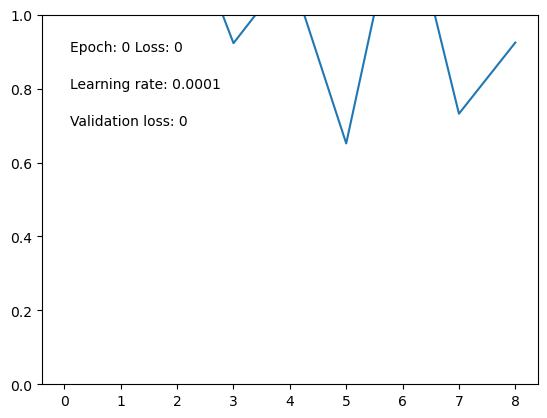

In [58]:
train(
    diffusion_imputer, 
    train_loader, 
    val_loader,
    batch_embedder = embedder,
    windowed_mode=True,
    min_window = 50,
    max_window = 100,
    device="cuda",
    epochs = 200,
    lr = 0.0001, 
    annealing_window = 5,
    annealing_multiplier = 1,
    loss_func = diffusion_imputer.loss_func,
    validation_frequency=2, 
    validation_prp=1)

In [ ]:
# train_hybrid(
#     diffusion_imputer, 
#     hybrid_model,
#     train_loader, 
#     val_loader,
#     batch_embedder = embedder,
#     epochs = 20,
#     lr = 0.001, 
#     annealing_window = 5,
#     annealing_multiplier = 1,
#     loss_func = diffusion_imputer.loss_func,
#     hybrid_loss_func = hybrid_model.loss_func,
#     hybrid_start_epoch = 0,
#     hybrid_every_n_epoch = 5,
#     validation_frequency=2, 
#     validation_prp=1)

In [35]:

# save the entire model for further training
torch.save(diffusion_imputer, "diffusion_imputer_random_sp500_may19.pt")

# Evaluation for random imputation

In [36]:
# diffusion_imputer = torch.load("diffusion_imputer_forecast_year_later_sp500_may11.pt")

In [37]:
# num_batch_test = 82
# data_loaders = get_dataloader(num_batch_test, "cuda")
# data_loader_test = get_dataloader(num_batch_test, "cuda")[2]

In [38]:
training_standard_deviation = 1#np.std(train_data.cpu().numpy())
training_mean = 0#np.mean(train_data.cpu().numpy())

training_standard_deviation
training_mean

1

0

In [39]:
test_data.shape

torch.Size([487, 660, 4])

In [67]:
#device = "mps:0"
device = "cuda"
# for i, batch in enumerate(test_loader):
#     test_data = batch.to("cuda")
test_data = sp_prepared[:, 850:, :]
test_data = test_data[30:50,100:160].to(device)
test_data = embedder(test_data).to(device)

imputation_mask = torch.zeros_like(test_data).to(device)

# random_mask = torch.rand_like(test_data)
# prp = 0.1
# imputation_mask[random_mask <= prp] = 1
# imputation_mask[:, :, :6] = 0

#do forecasting (random mask is 0 for the last 10 time steps) include all features except the first 4
imputation_mask[:, -2:, 6:] = 1

# imputation_mask[:, :, 11] = 1 #forecast the year later column

given_points = test_data * (1-imputation_mask)

eval_points = test_data * imputation_mask

In [69]:
sum(sum(sum(imputation_mask)))/imputation_mask.numel()


tensor(0.0048, device='cuda:0')

In [70]:
test_data.shape

torch.Size([20, 60, 7])

In [71]:
sample_number = 20
samples = []
for i in range(sample_number):
    samples.append(diffusion_imputer.eval(test_data.to(device), imputation_mask.to(device)))

mae =  0.022620871663093567
mae =  0.02345648594200611
mae =  0.022463541477918625
mae =  0.024117227643728256
mae =  0.021919483318924904
mae =  0.01960940845310688
mae =  0.021506961435079575
mae =  0.02389274537563324
mae =  0.018447639420628548
mae =  0.025196552276611328
mae =  0.021237358450889587
mae =  0.024377809837460518
mae =  0.02257351018488407
mae =  0.019813064485788345
mae =  0.021646415814757347
mae =  0.016916004940867424
mae =  0.024154605343937874
mae =  0.022358758375048637
mae =  0.017004162073135376
mae =  0.02665000595152378


In [389]:
# sample_number = 10
# samples = []
# for i in range(sample_number):
#     for x, batch in enumerate(test_loader):
#         test_data = batch.to(device)
#         imputation_mask = torch.zeros_like(test_data).to(device)
#         imputation_mask[:, -1:, 4:] = 1
#         given_points = test_data * (1-imputation_mask)
#         eval_points = test_data * imputation_mask
#         samples.append(diffusion_imputer.eval(test_data.to(device), imputation_mask.to(device)))

In [72]:
imputation_results = [samples[i][0] for i in range(len(samples))] # = imputation results, input data, mask, mae
imputation_results = torch.stack(imputation_results, dim = 0)

In [73]:
torch.mean(imputation_results[0])

tensor(0.0760, device='cuda:0')

In [74]:
#imputation_results = [(result * training_standard_deviation + training_mean) for result in imputation_results]

In [75]:
torch.mean(imputation_results[0])

tensor(0.0760, device='cuda:0')

In [76]:
denormed_data = test_data * training_standard_deviation + training_mean
denormed_data = denormed_data.cpu().detach()

given_points = given_points.cpu().detach()
eval_points = eval_points.cpu().detach()

In [77]:
# qlist = [0.05,0.25,0.5,0.75,0.95]
# quantiles_imp= []
# for q in qlist:
#     quantiles = torch.quantile(torch.stack(imputation_results), q, dim=0)
#     #also find the mean
#     #means = torch.mean(torch.stack(imputation_results), dim=0)
#     #add the means to quintiles as the last element
#     quantiles_imp.append(quantiles.cpu().numpy())
#     #quantiles_imp.append(quantiles.cpu().numpy() * (imputation_mask).cpu().numpy() + (denormed_data * (1 - imputation_mask.cpu())).cpu().numpy())

In [78]:
imputation_results.shape

torch.Size([20, 20, 60, 7])

In [79]:
qlist = [0.05, 0.25, 0.50, 0.75, 0.95]
#qlist = [0.5]
quantiles_imp = []
for q in qlist:
    quantiles = torch.quantile(imputation_results, q, dim=0, interpolation="linear")
    quantiles_imp.append(quantiles)

means = torch.mean(imputation_results, dim=0)
quantiles_imp.append(means)

quantiles_imp = torch.stack(quantiles_imp, dim=0).cpu()


In [80]:
quantiles_imp.shape

torch.Size([6, 20, 60, 7])

In [81]:
"""maes = []
for i in range(sample_number):
  raw = samples[0][1] * trn_std + trn_mean
  imputed = samples[0][0] * trn_std + trn_mean
  maes.append(torch.mean(torch.abs(raw[imputation_mask !=0] - imputed[imputation_mask !=0])).item())
print(sum(maes) / sample_number)"""  # WRONG

mae = torch.mean(torch.abs(denormed_data[imputation_mask.cpu() != 0] - torch.Tensor(quantiles_imp[2][imputation_mask.cpu() != 0]))).item()
print(mae)

0.008055145852267742


In [82]:
def quantile_loss(target, forecast, q: float, eval_points) -> float:
    return 2 * torch.sum(
        torch.abs((forecast - target) * eval_points * ((target <= forecast) * 1.0 - q))
    )


def calc_denominator(target, eval_points):
    return torch.sum(torch.abs(target * eval_points))


def calc_quantile_CRPS(target, forecast, eval_points, mean_scaler, scaler):
    target = target * scaler + mean_scaler
    forecast = forecast * scaler + mean_scaler

    quantiles = np.arange(0.05, 1.0, 0.05)
    denom = calc_denominator(target, eval_points)
    CRPS = 0
    for i in range(len(quantiles)):
        q_pred = []
        for j in range(len(forecast)):
            q_pred.append(torch.quantile(forecast[j : j + 1], quantiles[i], dim=1))
        q_pred = torch.cat(q_pred, 0)
        q_loss = quantile_loss(target, q_pred, quantiles[i], eval_points)
        CRPS += q_loss / denom
    return CRPS.item() / len(quantiles)


In [83]:
sample_number = 3

In [84]:
all_target = samples[0][1]  # input_data same for all samples (B, L, K)
all_generated_samples = torch.stack([samples[i][0] for i in range(sample_number)]).permute(1,0,2,3)  # (B, sample_num, L, K)
all_evalpoint = samples[0][2]  # mask same for all samples (B, L, K)
CRPS = calc_quantile_CRPS(all_target, all_generated_samples, all_evalpoint, training_mean, training_standard_deviation)
print(CRPS)

1.709521444220292


In [85]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [86]:
quantiles_imp.shape

torch.Size([6, 20, 60, 7])

In [94]:
#up vs down accuracy
#we will check if the closing price is higher or lower than last day's closing price and compare if the impuation is higher or lower than the last day's closing price

#closing price is the last feature
closing_price = test_data[:, -1, 6]
closing_price = closing_price.cpu().detach()

#imputation results for the closing price
imputation_results_closing_price = quantiles_imp[5][:, -1, 6]
imputation_results_closing_price = imputation_results_closing_price.cpu().detach()

print("closing price: ", closing_price)
print("imputation results closing price: ", imputation_results_closing_price)

#calculate accuracy based on sign
accuracy = np.isin(torch.sign(imputation_results_closing_price * closing_price).numpy(), [0, 1]).sum() / len(closing_price)

print("accuracy: ", accuracy)

closing price:  tensor([ 0.0006,  0.0016,  0.0030,  0.0000, -0.0130,  0.0033, -0.0006, -0.0021,
        -0.0092,  0.0043, -0.0068, -0.0002, -0.0044,  0.0017,  0.0078,  0.0049,
        -0.0071,  0.0097,  0.0053,  0.0013])
imputation results closing price:  tensor([ 0.0030,  0.0005,  0.0009,  0.0104, -0.0022, -0.0041,  0.0031, -0.0062,
         0.0108,  0.0047, -0.0042, -0.0065,  0.0107,  0.0050,  0.0062,  0.0048,
         0.0051,  0.0079,  0.0131,  0.0080])
accuracy:  0.75


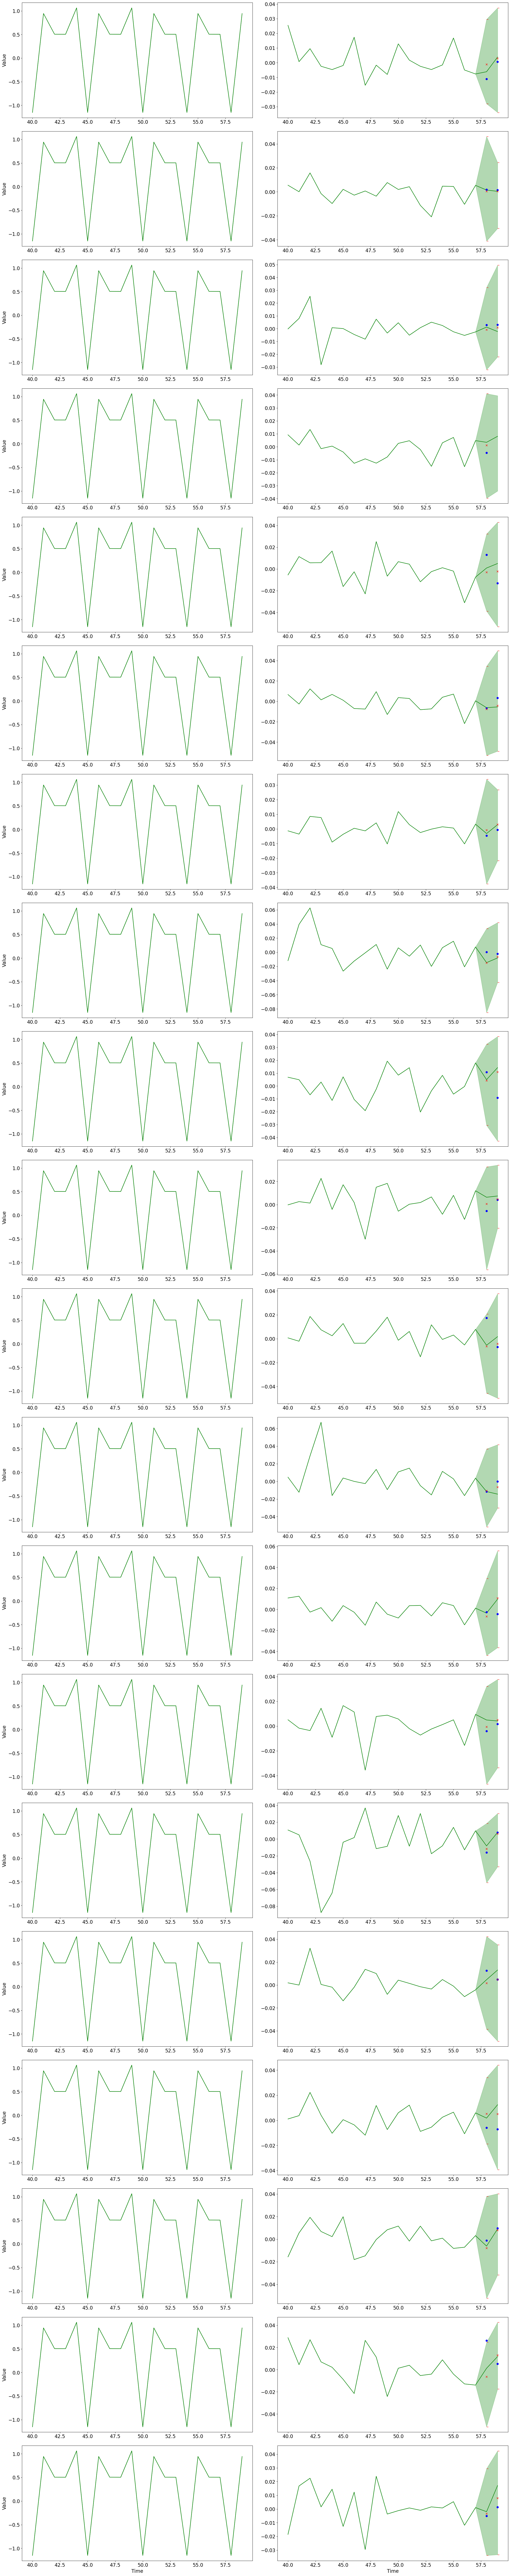

In [97]:
L = test_data.shape[1]
K = test_data.shape[2]

dataind = 20  # Number of samples to visualize
start_time = 40 
n_skip = 5  # Number of columns to skip

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=dataind, ncols=K - n_skip, figsize=(24.0, 6 * dataind))

for i in range(dataind):
    for k in range(n_skip, K):  # Start from n_skip instead of 0
        df = pd.DataFrame({
            "x": np.arange(start_time, L),
            "val": denormed_data[i, start_time:, k],
            "y": eval_points[i, start_time:, k]
        })
        df = df[df.y != 0]
        df2 = pd.DataFrame({
            "x": np.arange(start_time, L),
            "val": denormed_data[i, start_time:, k],
            "y": given_points[i, start_time:, k]
        })
        df2 = df2[df2.y != 0]
        indices = df.x.astype(int).to_numpy()
        row = i
        col = k - n_skip  # Adjust column index for skipped columns

        axes[row][col].plot(range(start_time, L), quantiles_imp[2][i, start_time:, k], color='g', linestyle='solid', label='median')
        axes[row][col].fill_between(range(start_time, L), quantiles_imp[0][i, start_time:, k], quantiles_imp[4][i, start_time:, k], color='g', alpha=0.3)
        axes[row][col].plot(df.x, df.val, color='b', marker='o', linestyle='None')
        axes[row][col].plot(df.x, quantiles_imp[5][i, indices, k], color='r', linestyle='None', label='median', marker='x')
        axes[row][col].plot(df.x, quantiles_imp[0][i, indices, k], color='r', linestyle='None', marker=1)
        axes[row][col].plot(df.x, quantiles_imp[4][i, indices, k], color='r', linestyle='None', marker=1)

        if col == 0:  # Only label the first of the remaining columns
            axes[row][col].set_ylabel('Value')
        if row == dataind - 1:  # Only label the last row
            axes[row][col].set_xlabel('Time')

# Optional: Adjust the layout for better spacing
plt.tight_layout()
plt.show()
